In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [3]:
# 550 data with 300 features
print(x_train.shape)

(550, 300)


In [4]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [5]:
def cross_validation(x_train, y_train, k=5):
    _shuffle = np.arange(len(x_train))
    np.random.shuffle(_shuffle)
    _kfold_data = []
    if len(x_train) / k == len(x_train) // k:
        fold_base = len(x_train) // k
        for i in range(k):
            group = []
            valid = np.array(_shuffle[i*fold_base:i*fold_base+fold_base])
            _train = []
            for data in _shuffle:
                if data not in valid:
                    _train.append(data)

            train = np.array(_train)
            group.append(train)
            group.append(valid)
            _kfold_data.append(group)
    else:
        fold_base = len(x_train) // k + 1
        group = []
        valid = np.array(_shuffle[:fold_base])
        train = np.array(_shuffle[fold_base:])
        group.append(train)
        group.append(valid)
        _kfold_data.append(group)
        
        fold_base -= 1
        for i in range(1, k):
            group = []
            valid = np.array(_shuffle[(i-1)*fold_base+(fold_base+1):(i-1)*fold_base+(fold_base+1)+fold_base])
            _train = []
            for data in _shuffle:
                if data not in valid:
                    _train.append(data)
            
            train = np.array(_train)
            group.append(train)
            group.append(valid)
            _kfold_data.append(group)

    return _kfold_data

In [6]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 55 # The number of data in each validation fold should equal to training data divieded by K

## example

In [7]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 0  1  2  5  6  8  9 10 11 12 13 14 15 17 18 19], Validation index: [ 3  4  7 16]
Split: 2, Training index: [ 1  2  3  4  6  7  8  9 10 11 12 14 16 17 18 19], Validation index: [ 0  5 13 15]
Split: 3, Training index: [ 0  1  2  3  4  5  6  7  8  9 10 13 15 16 17 18], Validation index: [11 12 14 19]
Split: 4, Training index: [ 0  3  4  5  6  7  8 11 12 13 14 15 16 17 18 19], Validation index: [ 1  2  9 10]
Split: 5, Training index: [ 0  1  2  3  4  5  7  9 10 11 12 13 14 15 16 19], Validation index: [ 6  8 17 18]


In [8]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C”, “kernel” and “gamma” to find the best parameters by cross-validation.

In [9]:
clf = SVC(C=1.0, kernel='rbf', gamma=0.01)

In [10]:
## your code
C_range = np.logspace(-2, 4, 7)
gamma_range = np.logspace(-4, 3, 8)
all_score = np.zeros((7, 8))
k_split = 5
svc_train = cross_validation(x_train, y_train, k=k_split)
best_score = 0
best_parameters = {}
for c in range(len(C_range)):
    for gamma in range(len(gamma_range)):
        avg_score = 0
        for split in range(len(svc_train)):
            train_X, train_y, valid_X, valid_y = [], [], [], []
            for train in svc_train[split][0]:
                train_X.append(x_train[train][:])
                train_y.append(y_train[train])
            
            for valid in svc_train[split][1]:
                valid_X.append(x_train[valid][:])
                valid_y.append(y_train[valid])
            
            svm = SVC(C=C_range[c], gamma=gamma_range[gamma])
            svm.fit(train_X, train_y)
            avg_score += svm.score(valid_X, valid_y)
        
        avg_score /= k_split
        all_score[c][gamma] = avg_score
        if avg_score > best_score:
            best_score = avg_score
            best_parameters = {'C':C_range[c], 'gamma':gamma_range[gamma]}

In [11]:
print(best_parameters)

{'C': 10.0, 'gamma': 0.001}


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like the reference image ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

[Text(69.0, 0.5, 'C Parameter'),
 Text(0.5, 33.0, 'Gamma Parameter'),
 Text(0.5, 1.0, 'Hyperparameter Gridsearch')]

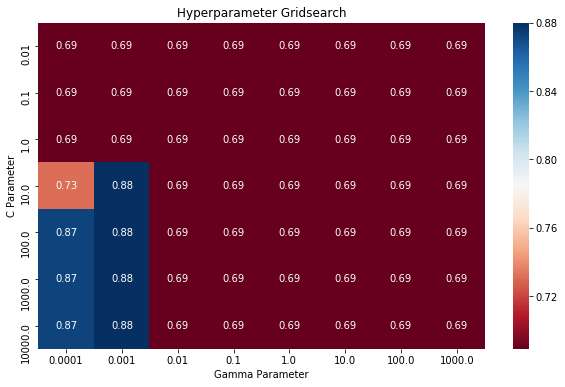

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(all_score, xticklabels=gamma_range, yticklabels=C_range, annot=True, cmap='RdBu')
ax.set(xlabel='Gamma Parameter', ylabel='C Parameter', title='Hyperparameter Gridsearch')

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set. **You accuracy should over 0.85**

In [13]:
best_model = SVC(C=best_parameters['C'], gamma=best_parameters['gamma'])
best_model.fit(x_train, y_train)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [14]:
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))

Accuracy score:  0.8958333333333334


## Question 5
Compare the performance of each model you have implemented from HW1

### HW1

In [15]:
train_df = pd.read_csv("./HW1/train_data.csv")
x_train = train_df['x_train'].to_numpy().reshape(-1,1)
y_train = train_df['y_train'].to_numpy().reshape(-1,1)

test_df = pd.read_csv("./HW1/test_data.csv")
x_test = test_df['x_test'].to_numpy().reshape(-1,1)
y_test = test_df['y_test'].to_numpy().reshape(-1,)

In [16]:
k_split = 5
svr_train = cross_validation(x_train, y_train, k=k_split)
best_score = 0
best_parameters = {}
all_score = np.zeros((7,8))
for c in range(len(C_range)):
    for gamma in range(len(gamma_range)):
        avg_score = 0
        for split in range(len(svr_train)):
            train_X, train_y, valid_X, valid_y = [], [], [], []
            for train in svr_train[split][0]:
                train_X.append(x_train[train][:])
                train_y.append(y_train[train][0])
            
            for valid in svr_train[split][1]:
                valid_X.append(x_train[valid][:])
                valid_y.append(y_train[valid][0])
            
            svm = SVR(C=C_range[c], gamma=gamma_range[gamma])
            svm.fit(train_X, train_y)
            avg_score += svm.score(valid_X, valid_y)
        
        avg_score /= k_split
        all_score[c][gamma] = avg_score
        if avg_score > best_score:
            best_score = avg_score
            best_parameters = {'C':C_range[c], 'gamma':gamma_range[gamma]}

In [17]:
print("best_parameters: ", best_parameters)
svr_model = SVR(C=best_parameters['C'], gamma=best_parameters['gamma'])
svr_model.fit(x_train, y_train)
y_pred = svr_model.predict(x_test)
MSE_svr = np.mean((y_test - y_pred)**2)

best_parameters:  {'C': 1000.0, 'gamma': 0.001}


C:\Users\ilike\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
print("Mean square error of Linear regression: ", 0.06794883148135622)
print("Mean square error of SVM regresssion model: ", MSE_svr)

Mean square error of Linear regression:  0.06794883148135622
Mean square error of SVM regresssion model:  0.07200436935357739


[Text(69.0, 0.5, 'C Parameter'),
 Text(0.5, 33.0, 'Gamma Parameter'),
 Text(0.5, 1.0, 'Hyperparameter Gridsearch')]

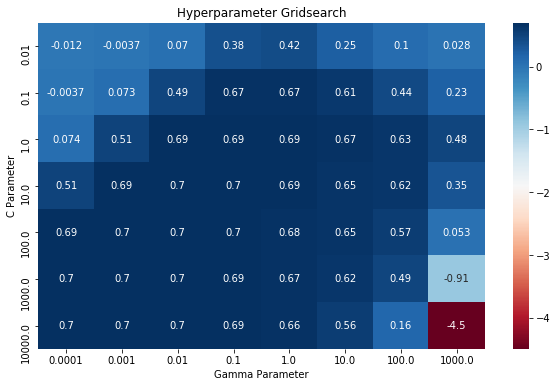

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(all_score, xticklabels=gamma_range, yticklabels=C_range, annot=True, cmap='RdBu')
ax.set(xlabel='Gamma Parameter', ylabel='C Parameter', title='Hyperparameter Gridsearch')